# TP1B — Localisation sur une route

**Objectif :** à partir d’un jeu d’images capturées le long d’une route (séquence ordonnée), mesurer la *familiarité* entre une image courante tirée aléatoirement sur la route et la **base de données** de cette route. Le but est de **retrouver** l’**index** et l’**angle** de cette image à l’aide de la familiarité. Les images du jeu de données sont des **images équirectangulaires** avec un **champ de vision** de **360° en azimut** et **90° en altitude** (±45°).

On construit la **rIDF** (*Rotational Image Difference Function*) pour chaque image de **référence** par rapport à l’image **test**, puis on estime :

* l’index de référence `j*` (l’image de la base de données la plus proche de l’image test),
* et l’angle `θ*` qui **minimise** la familiarité (erreur de cap) pour cette image de référence.

**Bibliothèques recommandées :** privilégier **OpenCV** (`cv2`) et **NumPy** ; utiliser **matplotlib** pour les graphiques.

**Plan du notebook**


## 0. Setup and Imports bib

In [32]:
COLAB = True
if COLAB:
    # === Téléchargement & extraction des données dans ./data ===========================
    from pathlib import Path
    import urllib.request, zipfile, tarfile, io, os

    # Indiquez le lien direct du dataset ; .zip / .tar.gz recommandés
    DATA_URL = "https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814"  # <-- REMPLACEZ-MOI (lien de données)
    DATA_DIR = Path("../data")
    DATA_DIR.mkdir(exist_ok=True)

    def download(url: str) -> bytes:
        print(f"Téléchargement depuis {url} …")
        with urllib.request.urlopen(url) as r:
            return r.read()

    blob = download(DATA_URL)

    # Détection simple des formats courants, sinon écriture binaire brute
    with zipfile.ZipFile(io.BytesIO(blob)) as zf:
        zf.extractall(DATA_DIR)

    # Aperçu du contenu
    print("Aperçu:", [p.name for p in DATA_DIR.glob('*')][:10])


Téléchargement depuis https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814 …
Aperçu: ['dataset_C', 'dataset_A', '.gitkeep', 'dataset_B']


In [33]:
DATA_DIR = "../data/dataset_B"  # <-- à adapter si besoin

import os
import random
import math
from pathlib import Path
import glob
from matplotlib import cm
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (nécessaire pour la surface 3D)

plt.rcParams["figure.figsize"] = (8, 5)


## 1. Import du jeu de données et visualisation

Les images doivent correspondre à une trajectoire **ordonnée** (index croissant ≈ progression sur la route). La fonction pour **charger** les images et les **métadonnées** dans une liste est fournie.

### TODO

* [ ] **Compléter** la fonction `parse_from_name(path_str)` qui récupère les métadonnées à partir du nom de fichier. Le format attendu est : `index_x_y_theta.jpg`.
* [ ] **Compléter** la fonction `plot_traj(images_meta)` qui prend la liste d’images et de poses et trace, en 2D, la pose **(x, y, θ)** de chaque image. L’orientation doit être représentée par une **flêche** (quiver) partant du point *(x, y)* dans la direction de l’angle **θ**.


Images chargées: 22


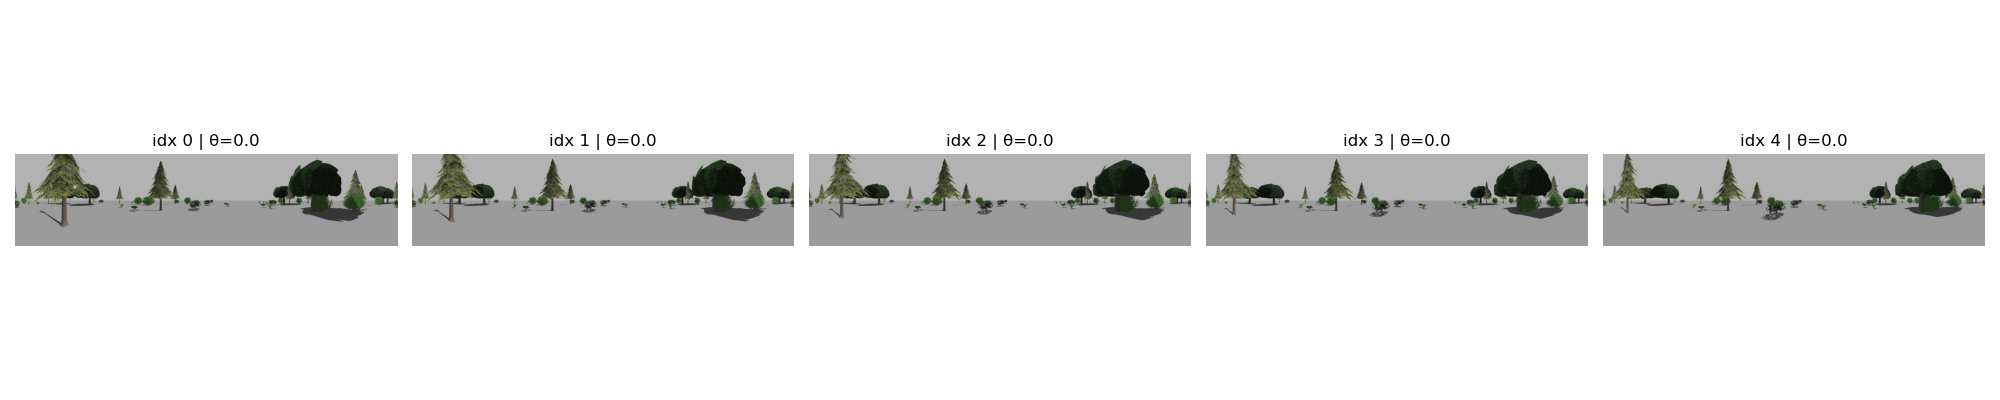

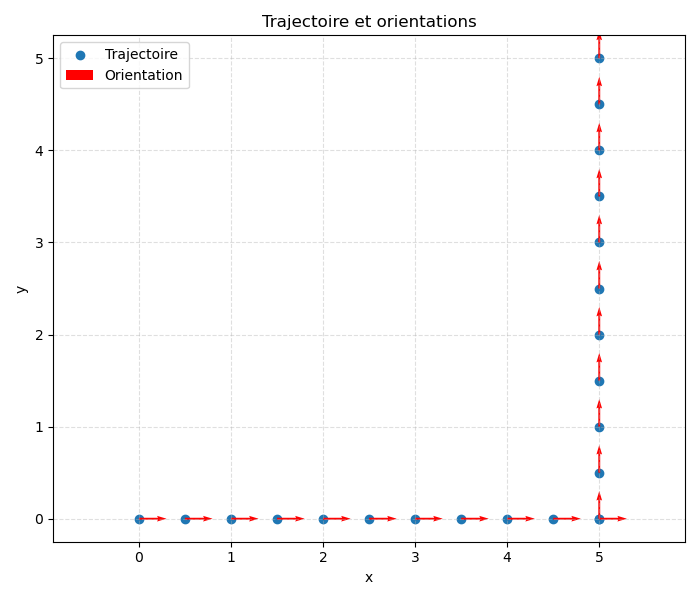

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Trajectoire et orientations'}, xlabel='x', ylabel='y'>)

In [34]:
def parse_from_name(path_str: str):
    # TODO : Parse image name an return the values
    """
    Attend des fichiers nommés: index_x_y_theta.jpg
    Parse sans regex (split par '_').
    """
    stem = Path(path_str).stem  # "index_x_y_theta"
    parts = stem.split('_')
    if len(parts) != 4:
        raise ValueError(f"Nom non conforme: {Path(path_str).name} (attendu: index_x_y_theta.jpg)")
    idx = int(parts[0])
    x = float(parts[1])
    y = float(parts[2])
    theta = float(parts[3])
    return idx, x, y, theta

def plot_traj(images_meta, scale=0.2, lw=1, color_traj="#1f77b4", color_dir="r"):
    # TODO : Plot the pose (x,y,theta) of each images in the dataset

    # Extraire x, y, theta (en degrés)
    xs = np.array([r["x"] for r in images_meta], dtype=float)
    ys = np.array([r["y"] for r in images_meta], dtype=float)
    thetas_deg = np.array([r["theta"] for r in images_meta], dtype=float)

    fig, ax = plt.subplots(figsize=(7, 6))
    # Trace la trajctoire XY
    ax.scatter(xs, ys, color=color_traj, lw=lw, label="Trajectoire")

    # Trace l’orientation à chaque point (flèches ou segments)
    th_rad = np.deg2rad(thetas_deg)
    dx = scale * np.cos(th_rad)
    dy = scale * np.sin(th_rad)
    ax.quiver(xs, ys, dx, dy, angles='xy', scale_units='xy', scale=1, color=color_dir, width=0.003, label="Orientation")

    # Style
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Trajectoire et orientations")
    ax.set_aspect("equal", adjustable="datalim")
    ax.grid(True, ls="--", alpha=0.4)
    ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

    return fig, ax

# fonction given that load the images and meta datas and output in a list
def load_images_cv(data_dir):
    """
    Retourne une liste triée par index:
      [{ 'img': ndarray int8 [0,255], 'index': int, 'x': float, 'y': float, 'theta': float, 'path': str }]
    """
    files = glob.glob(f"{data_dir}/*.jpg")

    # Parse + tri par index
    recs = []
    for p in files:
        try:
            idx, x, y, th = parse_from_name(p)
            recs.append((idx, x, y, th, p))
        except Exception as e:
            print("[warn]", e)
    recs.sort(key=lambda r: r[0])

    # Chargement OpenCV
    out = []
    for idx, x, y, th, p in recs:
        im = cv2.imread(p, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        out.append({"img": im, "index": idx, "x": x, "y": y, "theta": th, "path": p})
    return out

# TODO : load the dataset and print the number of images in the dataset
images_meta = load_images_cv(DATA_DIR)
images = [r["img"] for r in images_meta]
N = len(images_meta)
print(f"Images chargées: {N}")

# --- Aperçu ---
# TODO : Show 5 differents image from the dataset 
fig, axes = plt.subplots(1, 5, figsize=(4*5, 4))
for i in range(5):
    rec = images_meta[i]
    axes[i].imshow(rec["img"], cmap="gray")
    axes[i].set_title(f"idx {rec['index']} | θ={rec['theta']:.1f}")
    axes[i].axis("off")
plt.tight_layout(); plt.show()

# Given : call the plotter
plot_traj(images_meta, scale=0.3)



## 2. Familiarité et rIDF de chaque image sur la route

Ici, on calcule pour **chaque image** de la base de données la familiarité entre l’image de **référence** (orientée dans la direction de la route) et **ses versions tournées** d’un angle `θ`. Ensuite, on visualise la surface 3D de la rIDF, où **x = index d’image**, **y = θ testé**, **z = familiarité**.

**Fonctions données :**

* `shift_equirect(img, theta_rad)` — tourne l’image équirectangulaire d’un angle donné ;
* `nrmse(a, b)` — calcule la familiarité entre deux images ;
* `preprocess(img, target_hw=None, use_blur=False, sigma=1.0, use_sobel=False, colormode="gray")` — fonction de prétraitement (chaque image doit y passer) ; libre à vous de choisir les paramètres ; un exemple fonctionnel est fourni.

### TODO

* [ ] **Compléter** la fonction `ridf_nrmse_3d(imgs_ref, thetas_deg=np.arange(-180, 181, 1), target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green")` qui **prend** une base d’images de référence (la route, orientée dans la bonne direction), les **paramètres de scan**, et les **paramètres de prétraitement** (à transmettre à `preprocess`).
* [ ] **Appeler** cette fonction.
* [ ] **Tracer** la **surface 3D** (x = index, y = θ, z = familiarité).
* [ ] **Tracer** la **heatmap** (surface 3D vue du dessus).
* [ ] **Comparer** avec et sans prétraitement (modifier les paramètres) et **discuter** les différences.


/tmp/ipykernel_14286/3568262394.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


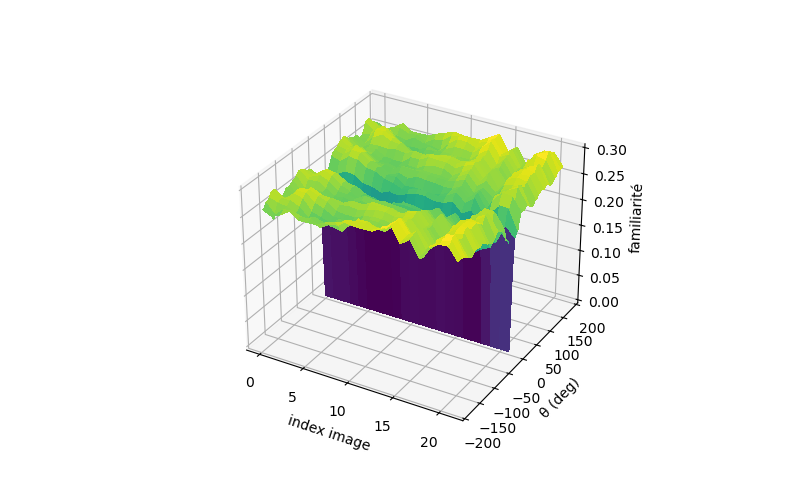

In [35]:

def shift_equirect(img, theta_rad):
    if img.ndim==2:
        H, W = img.shape
    else:
        H, W, _ = img.shape
    du = int(round((W * theta_rad) / (2*np.pi)))
    return np.roll(img, shift=du, axis=1)

def nrmse(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")
    diff = a - b
    mse = np.mean(diff*diff)
    return float(np.sqrt(mse))

def preprocess(img, target_hw=None, use_blur=False, sigma=1.0, use_sobel=False, colormode="gray"):
    """
    OpenCV-only: select channel/gray -> optional Gaussian blur -> optional resize -> optional Sobel magnitude.
    Returns float32 in [0,1].
    colormode: "gray", "blue", "green", "red"  (OpenCV reads BGR)
    target_hw: (H, W) or None
    """
    # channel / gray
    if img.ndim == 3:
        if colormode == "blue":   g = img[..., 0]
        elif colormode == "green":g = img[..., 1]
        elif colormode == "red":  g = img[..., 2]
        else:                     g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        g = img

    # to float32 [0,1]
    g = g.astype(np.float32)
    if g.max() > 1.0: g *= (1.0/255.0)

    # blur
    if use_blur and sigma > 0:
        g = cv2.GaussianBlur(g, (0, 0), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT)

    # resize
    if target_hw is not None:
        g = cv2.resize(g, (int(360/target_hw), int(90/target_hw)), interpolation=cv2.INTER_AREA)

    # sobel magnitude
    if use_sobel:
        gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
        gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)
        g = cv2.magnitude(gx, gy)
        m = g.max()
        if m > 0: g /= m

    return g

def ridf_nrmse_3d(imgs_ref, thetas_deg=np.arange(-180, 181, 1), target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green"):
    # TODO : Compute the ridf (familiaritiy vs scanned angle) for each image in the dataset and output list of index, angle, familiarity
    # each image will pass through the preprocess function
    Z = np.zeros((len(imgs_ref), len(thetas_deg)), dtype=np.float32)
    for i, im in enumerate(imgs_ref):
        for t_idx, th in enumerate(thetas_deg):
            im_res = preprocess(im, target_hw=target_hw, use_blur=use_blur, sigma=sigma, use_sobel=use_sobel, colormode=colormode)
            Z[i, t_idx] = nrmse(im_res, shift_equirect(im_res, np.deg2rad(th)))
    return Z

# TODO : Call the function and plot the surface x=index, y= theta, z=familiarity for a given scan parameter
# without preprocess for now
THETAS = np.arange(-180, 181, 5)  # <- à ajuster
Z_self = ridf_nrmse_3d(images, THETAS)

# Surface 3D: x = index image, y = theta, z = familiarité
X, Y = np.meshgrid(np.arange(Z_self.shape[0]), THETAS, indexing="ij")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_self, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel("index image")
ax.set_ylabel("θ (deg)")
ax.set_zlabel("familiarité")
plt.show()

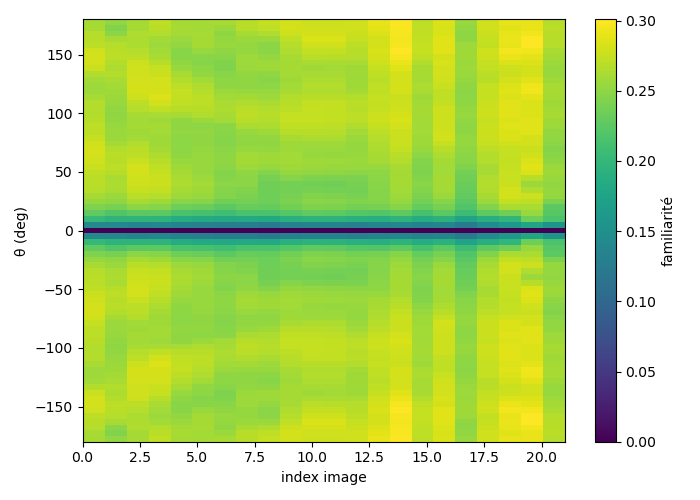

In [36]:
# TODO : Plot the heatmap (surface looking from top),  x = index image, y = θ, couleur = familiarité
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(
    Z_self.T,  # transpose: colonnes = index, lignes = θ
    extent=[0, Z_self.shape[0]-1, THETAS.min(), THETAS.max()],
    origin="lower",          # plus petits θ en bas
    aspect="auto",           # ne pas forcer un pixel carré
    interpolation="nearest", # rendu net
    cmap="viridis"
)
ax.set_xlabel("index image")
ax.set_ylabel("θ (deg)")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("familiarité")
plt.tight_layout()
plt.show()

## 3. Requête : une image **au hasard**, tournée d’un angle aléatoire

Cette fois, au lieu de calculer la surface 3D pour **chaque image** de la base par rapport à **elle-même**, on sélectionne **une image initiale**, prise **aléatoirement** sur la route, qu’on **tourne d’un angle aléatoire**. On calcule ensuite la **rIDF 3D** de cette image **test** par rapport à **chaque image de référence** de la base.

### TODO

* [ ] **Compléter** la fonction `ridf_nrmse_3d_query(imgs_ref, img_test=None, thetas_deg=np.arange(-180, 181, 1), target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green")`, qui prend les mêmes paramètres que `ridf_nrmse_3d` **avec**, en plus, une **image test**.
* [ ] **Sélectionner** une image **aléatoire** dans la base et la **tourner** d’un angle aléatoire.
* [ ] **Tracer** la **surface 3D** (x = index, y = θ, z = familiarité).
* [ ] **Tracer** la **heatmap** (surface 3D vue du dessus).
* [ ] **Varier** les paramètres et **tester différentes images/angles** aléatoires ; **analyser** les effets observés.


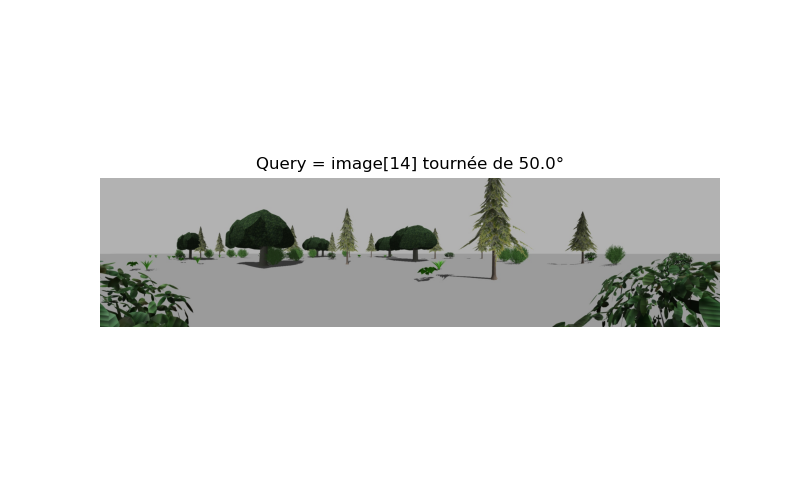

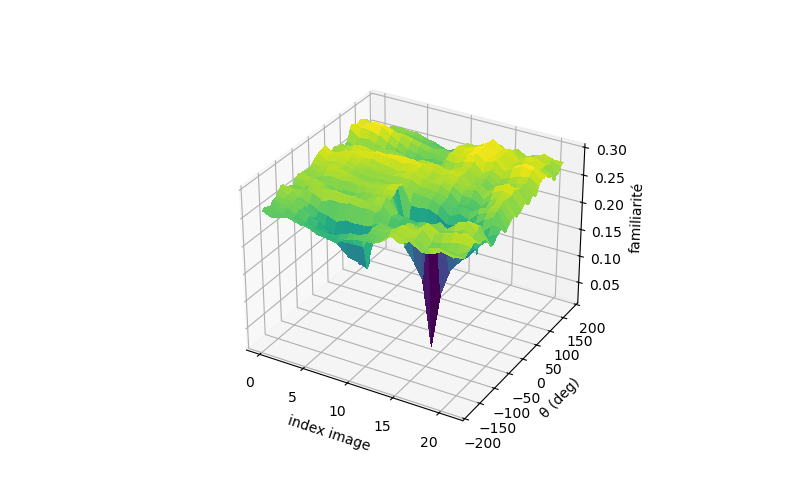

In [37]:
def ridf_nrmse_3d_query(imgs_ref, img_cur=None, thetas_deg=np.arange(-180, 181, 1), target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green"):
    # TODO : Compute the 3d ridf for each image in the dataset of reference according toa test images and specified params
    Z = np.zeros((len(imgs_ref), len(thetas_deg)), dtype=np.float32)
    if img_cur is not None:
        img_cur =  preprocess(img_cur, target_hw=target_hw, use_blur=use_blur, sigma=sigma, use_sobel=use_sobel, colormode=colormode)
    
    for i, im in enumerate(imgs_ref):
        for t_idx, th in enumerate(thetas_deg):
            im_res = preprocess(im, target_hw=target_hw, use_blur=use_blur, sigma=sigma, use_sobel=use_sobel, colormode=colormode)
            if img_cur is None:
                Z[i, t_idx] = nrmse(im_res, shift_equirect(im_res, np.deg2rad(th)))
            else: 
                Z[i, t_idx] = nrmse(im_res, shift_equirect(img_cur, np.deg2rad(th)))

    return Z

# TODO : Select a random image and a random angle and take the selected image rotated (use shift_equirect), call it query
k = random.randrange(len(images))
phi = 50.0  # angle choisi (deg) -> à modifier pour tester
img_test = shift_equirect(images[k], np.deg2rad(phi))

# Visualisation rapide de la requête
plt.figure()
plt.imshow(img_test)
plt.title(f"Query = image[{k}] tournée de {phi}°")
plt.axis("off")
plt.show()

# TODO : Call the function for a specific scan and plot the surface 3D, analyse the results
THETAS = np.arange(-180, 181, 5)  # <- à ajuster selon votre dataset (pas en degrés)
Z_img_test = ridf_nrmse_3d_query(images, img_test, THETAS, target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green")

# Surface 3D: x = index image, y = theta, z = familiarité
X, Y = np.meshgrid(np.arange(Z_img_test.shape[0]), THETAS, indexing="ij")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_img_test, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel("index image")
ax.set_ylabel("θ (deg)")
ax.set_zlabel("familiarité")
plt.show()

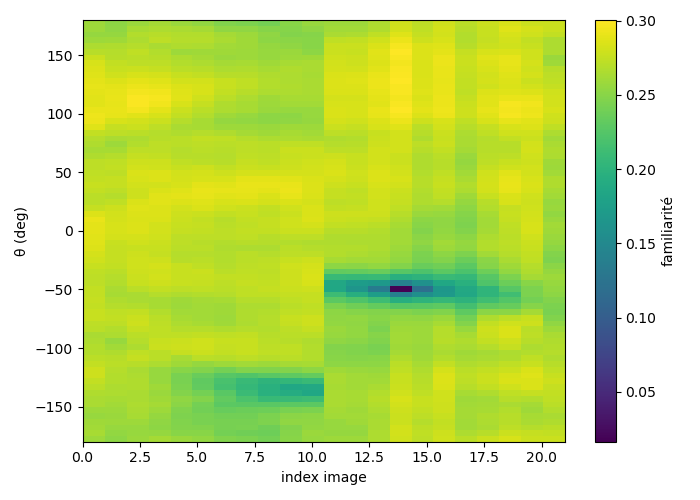

In [38]:
# TODO : Heatmap 2D de la RIDF : x = index image, y = θ, couleur = familiarité
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(
    Z_img_test.T,  # transpose: colonnes = index, lignes = θ
    extent=[0, Z_img_test.shape[0]-1, THETAS.min(), THETAS.max()],
    origin="lower",          # plus petits θ en bas
    aspect="auto",           # ne pas forcer un pixel carré
    interpolation="nearest", # rendu net
    cmap="viridis"
)
ax.set_xlabel("index image")
ax.set_ylabel("θ (deg)")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("familiarité")
plt.tight_layout()
plt.show()


## 4. Minimum de familiarité par index

Ici, on cherche automatiquement l’image de **référence** de la base qui se rapproche le plus de notre **image test**.

### TODO

* [ ] À partir des données calculées précédemment (section 3), **trouver le minimum de familiarité pour chaque index**.
* [ ] **Afficher** l’estimation de la **position sur la route** (l’index de l’image qui **minimise** la familiarité) ainsi que l’**erreur** entre le **vrai index** (celui utilisé pour générer l’image test) et l’**estimation**.
* [ ] **Tracer** en 2D la **familiarité minimale** obtenue pour chaque index.


Index candidat (argmin sur j) : j* = 14
Error estimation of position on the route = 0


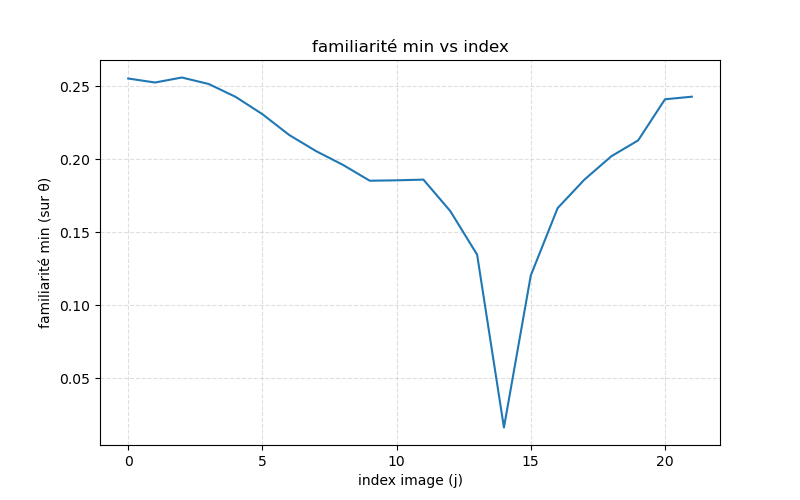

In [39]:
# TODO : Find the minimum of the familiarity for each index j and print the image index that minimize the familiarity 
# (i.e the estimated position on the route)
f_min = Z_img_test.min(axis=1)  # min sur θ pour chaque j
best_j = int(np.argmin(f_min))
print(f"Index candidat (argmin sur j) : j* = {best_j}")
print(f"Error estimation of position on the route = {best_j-k}")

# TODO : Plots the the minimum familiarity for each index
plt.figure()
plt.plot(np.arange(len(f_min)), f_min)
plt.xlabel("index image (j)")
plt.ylabel("familiarité min (sur θ)")
plt.title("familiarité min vs index")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

## 5. Minimum global (j*, θ*)

Enfin, on cherche le couple (j*, θ*) qui minimise λ(j, θ).
θ* est l’estimation de l’**erreur d’angle** (cap) entre l’image test et l’image de référence trouvée dans la **base de données** de la route.

### TODO

* [ ] À partir des données précédentes (section 3), estimer la **position sur la route** (j*) et l’**erreur de cap** (θ*).
* [ ] Tracer en 2D la **rIDF** (angle vs familiarité) pour la **position estimée** j*.


Minimum global -> j* = 14, θ* = -50.00°
Minimum global error -> j = 0, θ = 0.00°


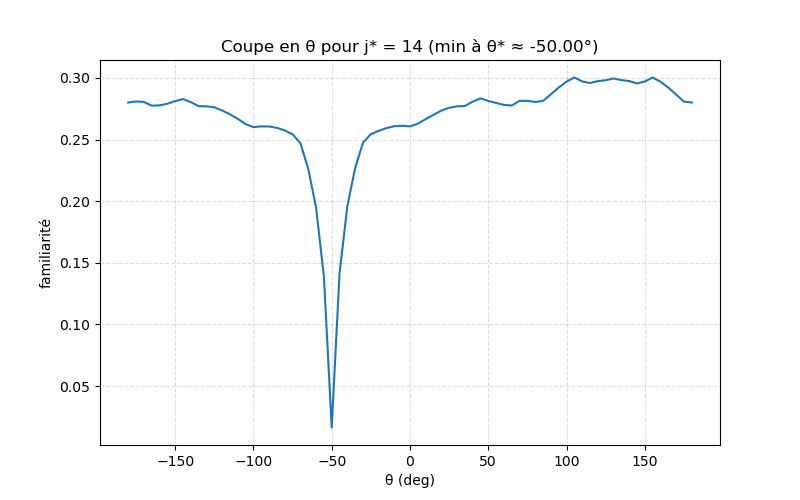

In [40]:

def find_global_minima(Z_img_test):
    # TODO : Compute the global minium to find the position estimation and the heading error. 
    flat_idx = int(np.argmin(Z_img_test))
    j_star, t_idx_star = np.unravel_index(flat_idx, Z_img_test.shape)
    theta_star = float(THETAS[t_idx_star])
    return j_star, theta_star

# Call and Print them and print the error between the heading error true (fixed earlier) and the estimated one
j_star,theta_star = find_global_minima(Z_img_test)
print(f"Minimum global -> j* = {j_star}, θ* = {theta_star:.2f}°")
print(f"Minimum global error -> j = {j_star-k}, θ = {-theta_star-phi:.2f}°")

# TODO : Plot the familiarity for each angle of the estimated closest image reference (position)
plt.figure()
plt.plot(THETAS, Z_img_test[j_star, :])
plt.xlabel("θ (deg)")
plt.ylabel("familiarité")
plt.title(f"Coupe en θ pour j* = {j_star} (min à θ* ≈ {theta_star:.2f}°)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Minimum global -> j* = 6, θ* = -130.00°
Minimum global error -> j = 0, θ = -1.01°
Temps complet : 5.69s


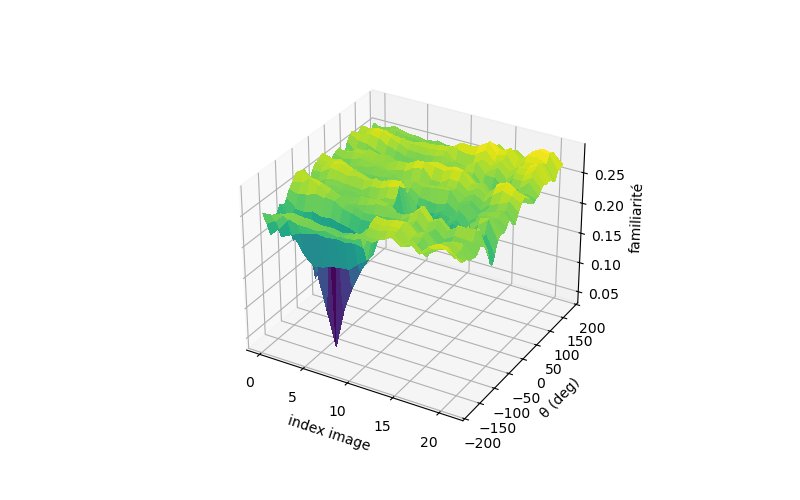

In [41]:
# TODO : Test with differents images, angles and image processing steps, print the estimated heading and position
# Print the error between the truth and the estimated
# Plots the surface 3d, explain 
# Print the time to compute the global minima 

k = random.randrange(len(images))
phi = random.uniform(-180, 180)
img_test = shift_equirect(images[k], np.deg2rad(phi))
THETAS = np.arange(-180, 181, 5)  # <- à ajuster selon votre dataset (pas en degrés)

ti = time.time()
Z_img_test = ridf_nrmse_3d_query(images, img_test, THETAS, target_hw=5, use_blur=True, sigma=1.0, use_sobel=True, colormode="green")
# Call and Print them and print the error between the heading error true (fixed earlier) and the estimated one
j_star,theta_star = find_global_minima(Z_img_test)
print(f"Minimum global -> j* = {j_star}, θ* = {theta_star:.2f}°")
print(f"Minimum global error -> j = {j_star-k}, θ = {-theta_star-phi:.2f}°")
ts = time.time() - ti
print(f'Temps complet : {ts:.2f}s')

# Surface 3D: x = index image, y = theta, z = familiarité
X, Y = np.meshgrid(np.arange(Z_img_test.shape[0]), THETAS, indexing="ij")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_img_test, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel("index image")
ax.set_ylabel("θ (deg)")
ax.set_zlabel("familiarité")
plt.show()

### À comprendre

> **Analyse en temps réel :**

> Pour **trouver l’erreur de cap**, **combien de temps** cela prend-il sur **votre machine** ?

> Pensez-vous que ce soit **faisable sur un Raspberry Pi** pour le **contrôle d’un robot en temps réel**, à une **vitesse de 0,5 m/s** ? **Combien de mètres aura-t-il parcouru** avant de prendre une décision ? **Comment peut-on améliorer le temps de réponse** ?
